## Keras with Hyperopt Hyperparamter Tuning

In [0]:
# imports 
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import mlflow
import mlflow.keras
from sklearn.model_selection import train_test_split
from hyperopt import fmin, hp, tpe, STATUS_OK, SparkTrials
from sklearn.preprocessing import StandardScaler
from mlflow.tracking import MlflowClient
import pandas as pd

client = MlflowClient()

# load the datasets 
userhome = 'dbfs:/user/skim658@gwu.edu'

redDF = spark.read.parquet(userhome + '/final-project/reddf.parquet')
whiteDF = spark.read.parquet(userhome + '/final-project/whitedf.parquet')

In [0]:
# split the dataset into train and test sets 
redPDDF = redDF.toPandas() 
redQuality = redPDDF['quality']
redPDDF.drop('quality', axis = 1, inplace = True)
redXTrain, redXTest, redYTrain, redYTest = train_test_split(redPDDF, redQuality, test_size = 0.2, random_state = 1)

In [0]:
whitePDDF = whiteDF.toPandas()
whiteQuality = whitePDDF['quality']
whitePDDF.drop('quality', axis = 1, inplace = True)
whiteXTrain, whiteXTest, whiteYTrain, whiteYTest = train_test_split(whitePDDF, whiteQuality, test_size = 0.2, random_state = 1)

In [0]:
import matplotlib.pyplot as plt

def viewModelLoss():
  plt.clf()
  plt.plot(history.history["loss"])
  plt.title("Model Loss")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.show()

In [0]:
def create_model(hpo):
  model = Sequential()
  model.add(Dense(int(hpo['dense_l1']), input_dim = 11, activation = 'relu'))
  model.add(Dense(int(hpo['dense_l2']), activation = 'relu'))
  model.add(Dense(1, activation = 'linear'))
  return model

In [0]:
searchSpace = {
  'dense_l1': hp.quniform('dense_l1', 10, 250, 1),
  'dense_l2': hp.quniform('dense_l2', 10, 250, 1),
  'learningRate': hp.loguniform('learningRate', -15, 0),
  'optimizer': hp.choice('optimizer', ['Adam']),
  'epochs': hp.quniform('epochs', 20, 50, 1)
}

## Red Wine

In [0]:
def runRNN(hpo):
  import tensorflow as tf
  
  model = create_model(hpo)
  
  # select optimizer 
  optimizerCall = getattr(tf.keras.optimizers, hpo['optimizer'])
  optimizer = optimizerCall(learning_rate = hpo['learningRate'])
  
  # compile and fit model 
  model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse'])
  history = model.fit(redXTrain, redYTrain, validation_split = 0.2, epochs = int(hpo['epochs']), verbose = 1)
  
  # evaluate model 
  score = model.evaluate(redXTest, redYTest, verbose = 1)
  obj_metric = score[0]
  return {'loss': obj_metric, 'status': STATUS_OK}

In [0]:
spark_trials = SparkTrials(parallelism = 4)

with mlflow.start_run():
  best_hyperparam = fmin(fn = runRNN, space = searchSpace, algo = tpe.suggest, max_evals = 100, trials = spark_trials)
  
  for name, value in best_hyperparam.items():
    mlflow.log_param(name, value)

print(best_hyperparam)

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/100 [00:00<?, ?trial/s, best loss=?] 1%| | 1/100 [00:20<34:05, 20.66s/trial, best loss: 0.49651676416397095] 2%|▏ | 2/100 [00:23<25:07, 15.38s/trial, best loss: 0.49651676416397095] 4%|▍ | 4/100 [00:28<18:25, 11.52s/trial, best loss: 0.49651676416397095] 5%|▌ | 5/100 [00:41<18:57, 11.97s/trial, best loss: 0.49651676416397095] 6%|▌ | 6/100 [00:43<14:04, 8.99s/trial, best loss: 0.49651676416397095] 7%|▋ | 7/100 [00:49<12:36, 8.14s/trial, best loss: 0.46237713098526]  8%|▊ | 8/100 [00:55<11:05, 7.23s/trial, best loss: 0.4290921688079834] 9%|▉ | 9/100 [01:02<10:52, 7.17s/trial, best loss: 0.4290921688079834] 10%|█ | 10/100 [01:05<08:53, 5.92s/trial, best loss: 0.4290921688079834] 11%|█ | 11/100 [01:10<08:23, 5.65s/trial, best loss: 0.4290921688079834] 12%|█▏ | 12/100 [01:16<08:27, 5.77s/trial, best loss: 0.4290921688079834] 13%|█▎ | 13/100 [01:23<08:54, 6.14s/trial, best loss: 0.4290921688079834] 14%|█▍ | 14/100 [01:26<07:27, 5.20s/trial, best loss: 0.4290921688079834] 15%|█▌ | 15/100 [01:31<07:17, 5.15s/trial, best loss: 0.4290921688079834] 16%|█▌ | 16/100 [01:41<09:15, 6.61s/trial, best loss: 0.4290921688079834] 17%|█▋ | 17/100 [01:47<08:56, 6.46s/trial, best loss: 0.4290921688079834] 18%|█▊ | 18/100 [01:50<07:26, 5.44s/trial, best loss: 0.4290921688079834] 19%|█▉ | 19/100 [01:53<06:23, 4.73s/trial, best loss: 0.4290921688079834] 20%|██ | 20/100 [02:06<09:40, 7.26s/trial, best loss: 0.4290921688079834] 21%|██ | 21/100 [02:09<07:58, 6.05s/trial, best loss: 0.41897302865982056] 22%|██▏ | 22/100 [02:13<06:45, 5.20s/trial, best loss: 0.41897302865982056] 23%|██▎ | 23/100 [02:20<07:25, 5.78s/trial, best loss: 0.41897302865982056] 24%|██▍ | 24/100 [02:28<08:12, 6.48s/trial, best loss: 0.41897302865982056] 25%|██▌ | 25/100 [02:33<07:39, 6.12s/trial, best loss: 0.39652538299560547] 26%|██▌ | 26/100 [02:35<06:04, 4.92s/trial, best loss: 0.39652538299560547] 27%|██▋ | 27/100 [02:40<06:04, 4.99s/trial, best loss: 0.39652538299560547] 28%|██▊ | 28/100 [02:47<06:45, 5.63s/trial, best loss: 0.39652538299560547] 29%|██▉ | 29/100 [02:57<07:53, 6.67s/trial, best loss: 0.39652538299560547] 30%|███ | 30/100 [03:00<06:33, 5.62s/trial, best loss: 0.39652538299560547] 31%|███ | 31/100 [03:05<06:17, 5.47s/trial, best loss: 0.39652538299560547] 32%|███▏ | 32/100 [03:12<06:45, 5.96s/trial, best loss: 0.39652538299560547] 33%|███▎ | 33/100 [03:19<07:01, 6.29s/trial, best loss: 0.39652538299560547] 34%|███▍ | 34/100 [03:24<06:32, 5.95s/trial, best loss: 0.39652538299560547] 35%|███▌ | 35/100 [03:28<05:51, 5.40s/trial, best loss: 0.39652538299560547] 36%|███▌ | 36/100 [03:36<06:37, 6.22s/trial, best loss: 0.39652538299560547] 37%|███▋ | 37/100 [03:45<07:10, 6.83s/trial, best loss: 0.37806829810142517] 38%|███▊ | 38/100 [03:49<06:13, 6.02s/trial, best loss: 0.37806829810142517] 39%|███▉ | 39/100 [03:56<06:28, 6.36s/trial, best loss: 0.37806829810142517] 40%|████ | 40/100 [04:02<06:18, 6.31s/trial, best loss: 0.37806829810142517] 41%|████ | 41/100 [04:08<06:09, 6.26s/trial, best loss: 0.37806829810142517] 42%|████▏ | 42/100 [04:13<05:43, 5.93s/trial, best loss: 0.37806829810142517] 43%|████▎ | 43/100 [04:22<06:16, 6.60s/trial, best loss: 0.37806829810142517] 44%|████▍ | 44/100 [04:29<06:18, 6.76s/trial, best loss: 0.37806829810142517] 45%|████▌ | 45/100 [04:33<05:29, 5.98s/trial, best loss: 0.37806829810142517] 46%|████▌ | 46/100 [04:40<05:42, 6.34s/trial, best loss: 0.37806829810142517] 47%|████▋ | 47/100 [04:46<

In [0]:
# display best hyperparameters 
redResult = pd.DataFrame(best_hyperparam, index = [0])
display(redResult)

dense_l1,dense_l2,epochs,learningRate,optimizer
169.0,76.0,46.0,0.013678454933188663,0


In [0]:
import math

# find best rmse 
temp = spark_trials.best_trial['result']
temp['rmse'] = math.sqrt(spark_trials.best_trial['result']['loss'])
redMetricsDF = pd.DataFrame(temp, index = [0])
display(redMetricsDF)

loss,status,rmse
0.37806829810142517,ok,0.6148725868840025


In [0]:
from tensorflow.keras import optimizers

# evaluate best model 
def build_model():
  return Sequential([Dense(best_hyperparam['dense_l1'], input_dim = 11, activation = 'relu'),
                    Dense(best_hyperparam['dense_l2'], activation = 'relu'),
                    Dense(1, activation = 'linear')])

loss = 'mse'
metrics = ['mse']
optimizer = optimizers.Adam(lr = best_hyperparam['learningRate'])

model = build_model()
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
history = model.fit(whiteXTrain, whiteYTrain, epochs = int(best_hyperparam['epochs']))

Epoch 1/46
 1/123 [..............................] - ETA: 0s - loss: 175.4679 - mse: 175.4679 37/123 [========>.....................] - ETA: 0s - loss: 155.5389 - mse: 155.5389 76/123 [=================>............] - ETA: 0s - loss: 77.0614 - mse: 77.0614 114/123 [==========================>...] - ETA: 0s - loss: 51.6729 - mse: 51.6729123/123 [==============================] - 0s 1ms/step - loss: 48.1651 - mse: 48.1651
Epoch 2/46
 1/123 [..............................] - ETA: 0s - loss: 0.7195 - mse: 0.7195 40/123 [========>.....................] - ETA: 0s - loss: 0.6856 - mse: 0.6856 79/123 [==================>...........] - ETA: 0s - loss: 0.6878 - mse: 0.6878115/123 [===========================>..] - ETA: 0s - loss: 0.7129 - mse: 0.7129123/123 [==============================] - 0s 1ms/step - loss: 0.7111 - mse: 0.7111
Epoch 3/46
 1/123 [..............................] - ETA: 0s - loss: 0.5973 - mse: 0.5973 40/123 [========>.....................] - ETA: 0s - loss: 0.7480 - mse: 0.7480 80/123 [==================>...........] - ETA: 0s - loss: 0.7193 - mse: 0.7193119/123 [============================>.] - ETA: 0s - loss: 0.6912 - mse: 0.6912123/123 [==============================] - 0s 1ms/step - loss: 0.6897 - mse: 0.6897
Epoch 4/46
 1/123 [..............................] - ETA: 0s - loss: 0.4755 - mse: 0.4755 40/123 [========>.....................] - ETA: 0s - loss: 0.6853 - mse: 0.6853 79/123 [==================>...........] - ETA: 0s - loss: 0.6828 - mse: 0.6828118/123 [===========================>..] - ETA: 0s - loss: 0.6489 - mse: 0.6489123/123 [==============================] - 0s 1ms/step - loss: 0.6466 - mse: 0.6466
Epoch 5/46
 1/123 [..............................] - ETA: 0s - loss: 0.5727 - mse: 0.5727 41/123 [=========>....................] - ETA: 0s - loss: 0.5962 - mse: 0.5962 81/123 [==================>...........] - ETA: 0s - loss: 0.6281 - mse: 0.6281117/123 [===========================>..] - ETA: 0s - loss: 0.6389 - mse: 0.6389123/123 [==============================] - 0s 1ms/step - loss: 0.6432 - mse: 0.6432
Epoch 6/46
 1/123 [..............................] - ETA: 0s - loss: 0.4916 - mse: 0.4916 40/123 [========>.....................] - ETA: 0s - loss: 0.6537 - mse: 0.6537

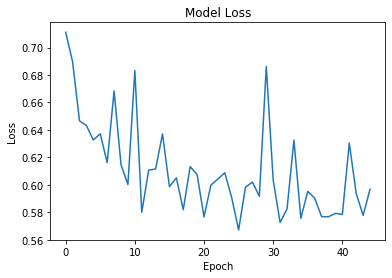

In [0]:
# remove outlier first epoch loss to prevent from squishing the graph down
del history.history['loss'][0]

viewModelLoss()

## White Wine

In [0]:
def runRNN(hpo):
  import tensorflow as tf
  
  model = create_model(hpo)
  
  # select optimizer 
  optimizerCall = getattr(tf.keras.optimizers, hpo['optimizer'])
  optimizer = optimizerCall(learning_rate = hpo['learningRate'])
  
  # compile and fit model 
  model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse'])
  history = model.fit(whiteXTrain, whiteYTrain, validation_split = 0.2, epochs = int(hpo['epochs']), verbose = 1)
  
  # evaluate model 
  score = model.evaluate(whiteXTest, whiteYTest, verbose = 1)
  obj_metric = score[0]
  return {'loss': obj_metric, 'status': STATUS_OK}

In [0]:
spark_trials = SparkTrials(parallelism = 4)

with mlflow.start_run():
  best_hyperparam = fmin(fn = runRNN, space = searchSpace, algo = tpe.suggest, max_evals = 100, trials = spark_trials)
  
  for name, value in best_hyperparam.items():  
    mlflow.log_param(name, value)

print(best_hyperparam)

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/100 [00:00<?, ?trial/s, best loss=?] 1%| | 1/100 [00:27<44:57, 27.25s/trial, best loss: 40.06336212158203] 2%|▏ | 2/100 [00:35<35:09, 21.53s/trial, best loss: 0.5680266618728638] 3%|▎ | 3/100 [00:37<25:20, 15.67s/trial, best loss: 0.5680266618728638] 4%|▍ | 4/100 [00:42<19:57, 12.48s/trial, best loss: 0.5680266618728638] 5%|▌ | 5/100 [01:04<24:17, 15.34s/trial, best loss: 0.5680266618728638] 6%|▌ | 6/100 [01:08<18:42, 11.95s/trial, best loss: 0.5680266618728638] 7%|▋ | 7/100 [01:17<17:09, 11.07s/trial, best loss: 0.5680266618728638] 8%|▊ | 8/100 [01:20<13:16, 8.66s/trial, best loss: 0.5680266618728638] 10%|█ | 10/100 [01:42<14:03, 9.37s/trial, best loss: 0.5680266618728638] 11%|█ | 11/100 [01:48<12:26, 8.39s/trial, best loss: 0.5680266618728638] 12%|█▏ | 12/100 [02:02<14:47, 10.08s/trial, best loss: 0.5680266618728638] 13%|█▎ | 13/100 [02:13<15:01, 10.36s/trial, best loss: 0.5680266618728638] 14%|█▍ | 14/100 [02:17<12:10, 8.50s/trial, best loss: 0.5580984950065613] 15%|█▌ | 15/100 [02:18<08:51, 6.26s/trial, best loss: 0.5580984950065613] 16%|█▌ | 16/100 [02:37<14:07, 10.09s/trial, best loss: 0.5580984950065613] 17%|█▋ | 17/100 [02:44<12:17, 8.89s/trial, best loss: 0.5580984950065613] 18%|█▊ | 18/100 [02:49<10:36, 7.76s/trial, best loss: 0.5580984950065613] 19%|█▉ | 19/100 [02:50<07:44, 5.73s/trial, best loss: 0.5580984950065613] 20%|██ | 20/100 [03:15<15:29, 11.62s/trial, best loss: 0.5444006323814392] 21%|██ | 21/100 [03:16<11:09, 8.48s/trial, best loss: 0.5444006323814392] 22%|██▏ | 22/100 [03:23<10:29, 8.08s/trial, best loss: 0.5444006323814392] 23%|██▎ | 23/100 [03:31<10:02, 7.82s/trial, best loss: 0.5444006323814392] 24%|██▍ | 24/100 [03:51<14:34, 11.51s/trial, best loss: 0.5444006323814392] 25%|██▌ | 25/100 [03:58<12:46, 10.22s/trial, best loss: 0.5444006323814392] 26%|██▌ | 26/100 [04:00<09:41, 7.86s/trial, best loss: 0.5358090400695801] 27%|██▋ | 27/100 [04:04<08:12, 6.75s/trial, best loss: 0.5358090400695801] 28%|██▊ | 28/100 [04:21<11:28, 9.56s/trial, best loss: 0.5358090400695801] 29%|██▉ | 29/100 [04:33<12:13, 10.33s/trial, best loss: 0.5358090400695801] 30%|███ | 30/100 [04:35<09:11, 7.88s/trial, best loss: 0.5358090400695801] 31%|███ | 31/100 [04:40<08:06, 7.06s/trial, best loss: 0.5358090400695801] 32%|███▏ | 32/100 [04:59<12:10, 10.74s/trial, best loss: 0.5353517532348633] 33%|███▎ | 33/100 [05:08<11:09, 9.99s/trial, best loss: 0.5353517532348633] 34%|███▍ | 34/100 [05:13<09:25, 8.56s/trial, best loss: 0.5353517532348633] 35%|███▌ | 35/100 [05:20<08:48, 8.12s/trial, best loss: 0.5353517532348633] 36%|███▌ | 36/100 [05:42<13:09, 12.33s/trial, best loss: 0.5353517532348633] 37%|███▋ | 37/100 [05:45<10:05, 9.61s/trial, best loss: 0.5353517532348633] 38%|███▊ | 38/100 [05:54<09:48, 9.49s/trial, best loss: 0.5353517532348633] 39%|███▉ | 39/100 [06:01<08:37, 8.48s/trial, best loss: 0.5353517532348633] 40%|████ | 40/100 [06:16<10:27, 10.47s/trial, best loss: 0.5353517532348633] 41%|████ | 41/100 [06:20<08:26, 8.59s/trial, best loss: 0.5353517532348633] 42%|████▏ | 42/100 [06:29<08:27, 8.75s/trial, best loss: 0.5353517532348633] 43%|████▎ | 43/100 [06:32<06:42, 7.06s/trial, best loss: 0.5353517532348633] 44%|████▍ | 44/100 [06:53<10:31, 11.28s/trial, best loss: 0.5353517532348633] 45%|████▌ | 45/100 [07:00<08:57, 9.78s/trial, best loss: 0.5353517532348633] 46%|████▌ | 46/100 [07:14<09:59, 11.10s/trial, best loss: 0.5353517532348633] 47%|████▋ | 47/100 [07:16<07:27, 8.45s/tri

In [0]:
# display best hyperparameters 
whiteResult = pd.DataFrame(best_hyperparam, index = [0])
display(whiteResult)

dense_l1,dense_l2,epochs,learningRate,optimizer
36.0,111.0,39.0,0.005318370097899995,0


In [0]:
# find best rmse 
temp = spark_trials.best_trial['result']
temp['rmse'] = math.sqrt(spark_trials.best_trial['result']['loss'])
whiteMetricsDF = pd.DataFrame(temp, index = [0])
display(whiteMetricsDF)

loss,status,rmse
0.5296145081520081,ok,0.7277461838800723


In [0]:
from tensorflow.keras import optimizers

# evaluate best model 
def build_model():
  return Sequential([Dense(best_hyperparam['dense_l1'], input_dim = 11, activation = 'relu'),
                    Dense(best_hyperparam['dense_l2'], activation = 'relu'),
                    Dense(1, activation = 'linear')])

loss = 'mse'
metrics = ['mse']
optimizer = optimizers.Adam(lr = best_hyperparam['learningRate'])

model = build_model()
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
history = model.fit(whiteXTrain, whiteYTrain, epochs = int(best_hyperparam['epochs']))

Epoch 1/39
 1/123 [..............................] - ETA: 0s - loss: 1650.7688 - mse: 1650.7688 45/123 [=========>....................] - ETA: 0s - loss: 116.2143 - mse: 116.2143  88/123 [====================>.........] - ETA: 0s - loss: 61.2366 - mse: 61.2366 123/123 [==============================] - 0s 1ms/step - loss: 44.5274 - mse: 44.5274
Epoch 2/39
 1/123 [..............................] - ETA: 0s - loss: 1.1906 - mse: 1.1906 46/123 [==========>...................] - ETA: 0s - loss: 1.1131 - mse: 1.1131 88/123 [====================>.........] - ETA: 0s - loss: 0.9724 - mse: 0.9724123/123 [==============================] - 0s 1ms/step - loss: 0.9522 - mse: 0.9522
Epoch 3/39
 1/123 [..............................] - ETA: 0s - loss: 0.6967 - mse: 0.6967 44/123 [=========>....................] - ETA: 0s - loss: 0.8753 - mse: 0.8753 87/123 [====================>.........] - ETA: 0s - loss: 0.8089 - mse: 0.8089123/123 [==============================] - 0s 1ms/step - loss: 0.7549 - mse: 0.7549
Epoch 4/39
 1/123 [..............................] - ETA: 0s - loss: 0.7515 - mse: 0.7515 45/123 [=========>....................] - ETA: 0s - loss: 0.7229 - mse: 0.7229 89/123 [====================>.........] - ETA: 0s - loss: 0.8108 - mse: 0.8108117/123 [===========================>..] - ETA: 0s - loss: 0.7962 - mse: 0.7962123/123 [==============================] - 0s 1ms/step - loss: 0.7960 - mse: 0.7960
Epoch 5/39
 1/123 [..............................] - ETA: 0s - loss: 0.5614 - mse: 0.5614 44/123 [=========>....................] - ETA: 0s - loss: 0.7248 - mse: 0.7248 89/123 [====================>.........] - ETA: 0s - loss: 0.7457 - mse: 0.7457123/123 [==============================] - 0s 1ms/step - loss: 0.7612 - mse: 0.7612
Epoch 6/39
 1/123 [..............................] - ETA: 0s - loss: 0.5049 - mse: 0.5049 46/123 [==========>...................] - ETA: 0s - loss: 0.6692 - mse: 0.6692 91/123 [=====================>........] - ETA: 0s - loss: 0.6548 - mse: 0.6548121/123 [============================>.] - ETA: 0s - loss: 0.7023 - mse: 0.7023123/123 [==============================] - 0s 1ms/step - loss: 0.7031 - mse: 0.7031
Epoch 7/39
 1/123 [..............................] - ETA: 0s - loss: 1.1194 - mse: 1.1194 47/123 [==========>...................] - ETA: 0s -

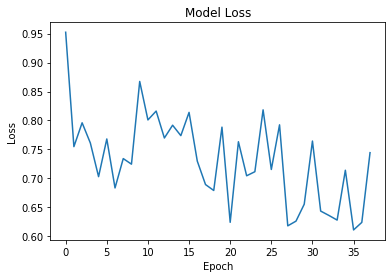

In [0]:
# remove outlier first epoch loss to prevent from squishing the graph down
del history.history['loss'][0]

viewModelLoss()

## Keras with Hyperopt Hyperparamter Tuning (Scaled Data)

In [0]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
redXTrainS = scaler.fit_transform(redXTrain)
redXTestS = scaler.transform(redXTest)

In [0]:
whiteXTrainS = scaler.fit_transform(whiteXTrain)
whiteXTestS = scaler.transform(whiteXTest)

## Red Wine

In [0]:
def runRNN(hpo):
  import tensorflow as tf
  
  model = create_model(hpo)
  
  # select optimizer 
  optimizerCall = getattr(tf.keras.optimizers, hpo['optimizer']) 
  optimizer = optimizerCall(learning_rate = hpo['learningRate'])
  
  # compile and fit model 
  model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse'])
  history = model.fit(redXTrainS, redYTrain, validation_split = 0.2, epochs = int(hpo['epochs']), verbose = 1)
  
  # evaluate model 
  score = model.evaluate(redXTestS, redYTest, verbose = 1)
  obj_metric = score[0]
  return {'loss': obj_metric, 'status': STATUS_OK}

In [0]:
spark_trials = SparkTrials(parallelism = 4)

with mlflow.start_run():
  best_hyperparam = fmin(fn = runRNN, space = searchSpace, algo = tpe.suggest, max_evals = 100, trials = spark_trials)
  
  for name, value in best_hyperparam.items():
    mlflow.log_param(name, value)

print(best_hyperparam)

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/100 [00:00<?, ?trial/s, best loss=?] 1%| | 1/100 [00:15<25:03, 15.19s/trial, best loss: 0.45893892645835876] 2%|▏ | 2/100 [00:21<20:18, 12.44s/trial, best loss: 0.45893892645835876] 3%|▎ | 3/100 [00:24<15:32, 9.61s/trial, best loss: 0.45893892645835876] 4%|▍ | 4/100 [00:27<12:12, 7.63s/trial, best loss: 0.45893892645835876] 5%|▌ | 5/100 [00:38<13:41, 8.65s/trial, best loss: 0.45893892645835876] 6%|▌ | 6/100 [00:41<10:53, 6.96s/trial, best loss: 0.45893892645835876] 7%|▋ | 7/100 [00:48<10:49, 6.98s/trial, best loss: 0.45893892645835876] 8%|▊ | 8/100 [00:49<08:02, 5.25s/trial, best loss: 0.42727071046829224] 9%|▉ | 9/100 [00:58<09:40, 6.38s/trial, best loss: 0.42727071046829224] 10%|█ | 10/100 [01:02<08:30, 5.67s/trial, best loss: 0.42727071046829224] 11%|█ | 11/100 [01:07<08:07, 5.47s/trial, best loss: 0.42727071046829224] 12%|█▏ | 12/100 [01:11<07:23, 5.04s/trial, best loss: 0.42727071046829224] 13%|█▎ | 13/100 [01:23<10:20, 7.13s/trial, best loss: 0.42727071046829224] 14%|█▍ | 14/100 [01:25<08:01, 5.60s/trial, best loss: 0.42727071046829224] 16%|█▌ | 16/100 [01:32<06:57, 4.97s/trial, best loss: 0.42727071046829224] 17%|█▋ | 17/100 [01:43<09:25, 6.82s/trial, best loss: 0.42727071046829224] 18%|█▊ | 18/100 [01:49<09:01, 6.60s/trial, best loss: 0.42727071046829224] 19%|█▉ | 19/100 [01:54<08:19, 6.16s/trial, best loss: 0.42727071046829224] 20%|██ | 20/100 [01:57<06:35, 4.94s/trial, best loss: 0.42727071046829224] 21%|██ | 21/100 [02:08<08:56, 6.79s/trial, best loss: 0.42727071046829224] 22%|██▏ | 22/100 [02:13<08:15, 6.35s/trial, best loss: 0.42165541648864746] 23%|██▎ | 23/100 [02:18<07:41, 6.00s/trial, best loss: 0.42165541648864746] 24%|██▍ | 24/100 [02:20<06:06, 4.83s/trial, best loss: 0.42165541648864746] 25%|██▌ | 25/100 [02:31<08:23, 6.71s/trial, best loss: 0.42165541648864746] 26%|██▌ | 26/100 [02:39<08:26, 6.84s/trial, best loss: 0.42165541648864746] 28%|██▊ | 28/100 [02:42<06:18, 5.25s/trial, best loss: 0.42165541648864746] 29%|██▉ | 29/100 [02:54<08:43, 7.37s/trial, best loss: 0.41667699813842773] 30%|███ | 30/100 [02:59<07:47, 6.68s/trial, best loss: 0.41667699813842773] 31%|███ | 31/100 [03:03<06:47, 5.91s/trial, best loss: 0.41667699813842773] 32%|███▏ | 32/100 [03:05<05:24, 4.77s/trial, best loss: 0.41667699813842773] 33%|███▎ | 33/100 [03:16<07:26, 6.67s/trial, best loss: 0.41667699813842773] 34%|███▍ | 34/100 [03:22<07:09, 6.51s/trial, best loss: 0.41667699813842773] 35%|███▌ | 35/100 [03:25<05:37, 5.20s/trial, best loss: 0.41667699813842773] 36%|███▌ | 36/100 [03:28<04:52, 4.58s/trial, best loss: 0.41667699813842773] 37%|███▋ | 37/100 [03:40<07:10, 6.83s/trial, best loss: 0.41667699813842773] 39%|███▉ | 39/100 [03:45<05:38, 5.56s/trial, best loss: 0.41667699813842773] 40%|████ | 40/100 [03:49<05:11, 5.19s/trial, best loss: 0.41667699813842773] 41%|████ | 41/100 [04:01<07:08, 7.27s/trial, best loss: 0.41667699813842773] 42%|████▏ | 42/100 [04:10<07:18, 7.55s/trial, best loss: 0.41667699813842773] 43%|████▎ | 43/100 [04:11<05:21, 5.64s/trial, best loss: 0.41667699813842773] 44%|████▍ | 44/100 [04:12<03:57, 4.25s/trial, best loss: 0.41667699813842773] 45%|████▌ | 45/100 [04:24<06:05, 6.64s/trial, best loss: 0.41667699813842773] 46%|████▌ | 46/100 [04:32<06:22, 7.09s/trial, best loss: 0.41667699813842773] 47%|████▋ | 47/100 [04:34<04:57, 5.62s/trial, best loss: 0.41667699813842773] 48%|████▊ | 48/100 [04:37<03:59, 4.60s/trial, best loss: 0.41667699813842773] 49%|████▉ | 4

In [0]:
# display best hyperparameters 
redResult = pd.DataFrame(best_hyperparam, index = [0])
display(redResult)

dense_l1,dense_l2,epochs,learningRate,optimizer
86.0,188.0,46.0,0.16788455127247046,0


In [0]:
# find best rmse 
temp = spark_trials.best_trial['result']
temp['rmse'] = math.sqrt(spark_trials.best_trial['result']['loss'])
redMetricsDF = pd.DataFrame(temp, index = [0])
display(redMetricsDF)

loss,status,rmse
0.40559545159339905,ok,0.6368637621920398


In [0]:
from tensorflow.keras import optimizers

# evaluate best model 
def build_model():
  return Sequential([Dense(best_hyperparam['dense_l1'], input_dim = 11, activation = 'relu'),
                    Dense(best_hyperparam['dense_l2'], activation = 'relu'),
                    Dense(1, activation = 'linear')])

loss = 'mse'
metrics = ['mse']
optimizer = optimizers.Adam(lr = best_hyperparam['learningRate'])

model = build_model()
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
history = model.fit(whiteXTrain, whiteYTrain, epochs = int(best_hyperparam['epochs']))

Epoch 1/46
 1/123 [..............................] - ETA: 0s - loss: 324.6389 - mse: 324.6389 39/123 [========>.....................] - ETA: 0s - loss: 176994.3281 - mse: 176994.3281 75/123 [=================>............] - ETA: 0s - loss: 92037.7344 - mse: 92037.7344 114/123 [==========================>...] - ETA: 0s - loss: 60551.4375 - mse: 60551.4375123/123 [==============================] - 0s 1ms/step - loss: 56378.7266 - mse: 56378.7266
Epoch 2/46
 1/123 [..............................] - ETA: 0s - loss: 0.6871 - mse: 0.6871 39/123 [========>.....................] - ETA: 0s - loss: 0.7689 - mse: 0.7689 78/123 [==================>...........] - ETA: 0s - loss: 0.7806 - mse: 0.7806118/123 [===========================>..] - ETA: 0s - loss: 0.8005 - mse: 0.8005123/123 [==============================] - 0s 1ms/step - loss: 0.8018 - mse: 0.8018
Epoch 3/46
 1/123 [..............................] - ETA: 0s - loss: 0.5826 - mse: 0.5826 39/123 [========>.....................] - ETA: 0s - loss: 0.7532 - mse: 0.7532 78/123 [==================>...........] - ETA: 0s - loss: 0.8108 - mse: 0.8108115/123 [===========================>..] - ETA: 0s - loss: 0.8180 - mse: 0.8180123/123 [==============================] - 0s 1ms/step - loss: 0.8134 - mse: 0.8134
Epoch 4/46
 1/123 [..............................] - ETA: 0s - loss: 0.8558 - mse: 0.8558 40/123 [========>.....................] - ETA: 0s - loss: 0.9201 - mse: 0.9201 74/123 [=================>............] - ETA: 0s - loss: 0.9536 - mse: 0.9536103/123 [========================>.....] - ETA: 0s - loss: 0.9143 - mse: 0.9143123/123 [==============================] - 0s 1ms/step - loss: 0.8923 - mse: 0.8923
Epoch 5/46
 1/123 [..............................] - ETA: 0s - loss: 0.7208 - mse: 0.7208 41/123 [=========>....................] - ETA: 0s - loss: 0.9008 - mse: 0.9008 81/123 [==================>...........] - ETA: 0s - loss: 0.8534 - mse: 0.8534120/123 [============================>.] - ETA: 0s - loss: 0.8101 - mse: 0.8101123/123 [==============================] - 0s 1ms/step - loss: 0.8091 - mse: 0.8091
Epoch 6/46
 1/123 [..............................] - ETA: 0s - loss: 0.9222 - mse: 0.9222 39/123 [========>.....................] - ETA: 0s - loss: 0.8360 - mse: 0.8360

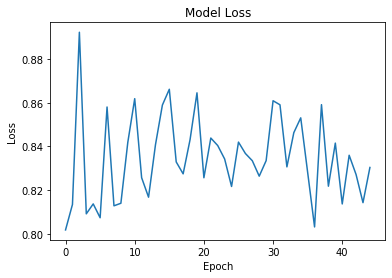

In [0]:
# remove outlier first epoch loss to prevent from squishing the graph down
del history.history['loss'][0]

viewModelLoss()

## White Wine

In [0]:
def runRNN(hpo):
  import tensorflow as tf
  
  model = create_model(hpo)
  
  # select optimizer 
  optimizerCall = getattr(tf.keras.optimizers, hpo['optimizer'])
  optimizer = optimizerCall(learning_rate = hpo['learningRate'])
  
  # compile and fit model 
  model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse'])
  history = model.fit(whiteXTrainS, whiteYTrain, validation_split = 0.2, epochs = int(hpo['epochs']), verbose = 1)
  
  # evaluate model 
  score = model.evaluate(whiteXTestS, whiteYTest, verbose = 1)
  obj_metric = score[0]
  return {'loss': obj_metric, 'status': STATUS_OK}

In [0]:
spark_trials = SparkTrials(parallelism = 4)

with mlflow.start_run():
  best_hyperparam = fmin(fn = runRNN, space = searchSpace, algo = tpe.suggest, max_evals = 100, trials = spark_trials)
  
  for name, value in best_hyperparam.items():
    mlflow.log_param(name, value)

print(best_hyperparam)

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/100 [00:00<?, ?trial/s, best loss=?] 1%| | 1/100 [00:27<44:54, 27.22s/trial, best loss: 8.9468412399292] 2%|▏ | 2/100 [00:29<32:06, 19.66s/trial, best loss: 8.9468412399292] 4%|▍ | 4/100 [00:31<22:32, 14.08s/trial, best loss: 0.5719371438026428] 5%|▌ | 5/100 [00:54<26:33, 16.77s/trial, best loss: 0.5719371438026428] 6%|▌ | 6/100 [00:56<19:24, 12.39s/trial, best loss: 0.5708365440368652] 7%|▋ | 7/100 [01:03<16:42, 10.78s/trial, best loss: 0.5708365440368652] 8%|▊ | 8/100 [01:04<12:02, 7.85s/trial, best loss: 0.5708365440368652] 9%|▉ | 9/100 [01:34<21:59, 14.51s/trial, best loss: 0.5708365440368652] 10%|█ | 10/100 [01:43<19:22, 12.92s/trial, best loss: 0.5006881356239319] 11%|█ | 11/100 [01:44<13:51, 9.34s/trial, best loss: 0.5006881356239319] 12%|█▏ | 12/100 [01:45<10:02, 6.84s/trial, best loss: 0.5006881356239319] 14%|█▍ | 14/100 [02:10<12:12, 8.52s/trial, best loss: 0.4960062503814697] 15%|█▌ | 15/100 [02:18<11:52, 8.38s/trial, best loss: 0.4960062503814697] 16%|█▌ | 16/100 [02:19<08:38, 6.17s/trial, best loss: 0.4960062503814697] 17%|█▋ | 17/100 [02:49<18:09, 13.13s/trial, best loss: 0.4960062503814697] 18%|█▊ | 18/100 [02:50<12:58, 9.49s/trial, best loss: 0.4960062503814697] 19%|█▉ | 19/100 [02:56<11:28, 8.51s/trial, best loss: 0.4960062503814697] 20%|██ | 20/100 [03:00<09:35, 7.19s/trial, best loss: 0.4960062503814697] 21%|██ | 21/100 [03:30<18:31, 14.07s/trial, best loss: 0.4960062503814697] 22%|██▏ | 22/100 [03:32<13:39, 10.50s/trial, best loss: 0.4960062503814697] 23%|██▎ | 23/100 [03:42<12:58, 10.11s/trial, best loss: 0.4960062503814697] 24%|██▍ | 24/100 [03:43<09:20, 7.38s/trial, best loss: 0.4960062503814697] 25%|██▌ | 25/100 [04:04<14:23, 11.52s/trial, best loss: 0.4960062503814697] 26%|██▌ | 26/100 [04:12<13:02, 10.57s/trial, best loss: 0.49196138978004456] 27%|██▋ | 27/100 [04:21<12:20, 10.15s/trial, best loss: 0.49196138978004456] 28%|██▊ | 28/100 [04:25<10:00, 8.34s/trial, best loss: 0.49196138978004456] 29%|██▉ | 29/100 [04:37<11:12, 9.47s/trial, best loss: 0.49196138978004456] 30%|███ | 30/100 [04:49<11:37, 9.97s/trial, best loss: 0.49196138978004456] 31%|███ | 31/100 [05:05<13:40, 11.89s/trial, best loss: 0.4889046847820282]  32%|███▏ | 32/100 [05:10<11:12, 9.89s/trial, best loss: 0.4889046847820282] 33%|███▎ | 33/100 [05:19<10:47, 9.67s/trial, best loss: 0.4889046847820282] 34%|███▍ | 34/100 [05:27<10:08, 9.21s/trial, best loss: 0.4889046847820282] 35%|███▌ | 35/100 [05:46<12:52, 11.88s/trial, best loss: 0.4889046847820282] 36%|███▌ | 36/100 [05:55<11:49, 11.08s/trial, best loss: 0.4889046847820282] 37%|███▋ | 37/100 [06:09<12:36, 12.01s/trial, best loss: 0.4889046847820282] 38%|███▊ | 38/100 [06:15<10:35, 10.25s/trial, best loss: 0.4889046847820282] 39%|███▉ | 39/100 [06:38<14:22, 14.14s/trial, best loss: 0.4889046847820282] 40%|████ | 40/100 [06:42<10:53, 10.89s/trial, best loss: 0.4889046847820282] 41%|████ | 41/100 [06:57<11:58, 12.17s/trial, best loss: 0.4889046847820282] 42%|████▏ | 42/100 [06:58<08:35, 8.89s/trial, best loss: 0.4747653603553772] 43%|████▎ | 43/100 [07:26<13:55, 14.67s/trial, best loss: 0.4747653603553772] 44%|████▍ | 44/100 [07:29<10:14, 10.97s/trial, best loss: 0.4747653603553772] 45%|████▌ | 45/100 [07:43<10:56, 11.93s/trial, best loss: 0.4747653603553772] 46%|████▌ | 46/100 [07:46<08:21, 9.29s/trial, best loss: 0.4747653603553772] 47%|████▋ | 47/100 [08:03<10:17, 11.65s/trial, best loss: 0.4747653603553772] 48%|████▊ | 48/100 [08:04<07:1

In [0]:
# display best hyperparameters 
whiteResult = pd.DataFrame(best_hyperparam, index = [0])
display(whiteResult)

dense_l1,dense_l2,epochs,learningRate,optimizer
186.0,204.0,43.0,3.4640369968820577E-4,0


In [0]:
# find best rmse 
temp = spark_trials.best_trial['result']
temp['rmse'] = math.sqrt(spark_trials.best_trial['result']['loss'])
whiteMetricsDF = pd.DataFrame(temp, index = [0])
display(whiteMetricsDF)

loss,status,rmse
0.46995702385902405,ok,0.6855341157513782


In [0]:
from tensorflow.keras import optimizers

# evaluate best model 
def build_model():
  return Sequential([Dense(best_hyperparam['dense_l1'], input_dim = 11, activation = 'relu'),
                    Dense(best_hyperparam['dense_l2'], activation = 'relu'),
                    Dense(1, activation = 'linear')])

loss = 'mse'
metrics = ['mse']
optimizer = optimizers.Adam(lr = best_hyperparam['learningRate'])

model = build_model()
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
history = model.fit(whiteXTrain, whiteYTrain, epochs = int(best_hyperparam['epochs']))

Epoch 1/43
 1/123 [..............................] - ETA: 0s - loss: 22.7815 - mse: 22.7815 33/123 [=======>......................] - ETA: 0s - loss: 5.0767 - mse: 5.0767  67/123 [===============>..............] - ETA: 0s - loss: 3.2666 - mse: 3.2666102/123 [=======================>......] - ETA: 0s - loss: 2.4614 - mse: 2.4614123/123 [==============================] - 0s 2ms/step - loss: 2.1853 - mse: 2.1853
Epoch 2/43
 1/123 [..............................] - ETA: 0s - loss: 1.5575 - mse: 1.5575 35/123 [=======>......................] - ETA: 0s - loss: 0.8277 - mse: 0.8277 68/123 [===============>..............] - ETA: 0s - loss: 0.8812 - mse: 0.8812103/123 [========================>.....] - ETA: 0s - loss: 0.8132 - mse: 0.8132123/123 [==============================] - 0s 1ms/step - loss: 0.7951 - mse: 0.7951
Epoch 3/43
 1/123 [..............................] - ETA: 0s - loss: 1.1051 - mse: 1.1051 35/123 [=======>......................] - ETA: 0s - loss: 0.8128 - mse: 0.8128 69/123 [===============>..............] - ETA: 0s - loss: 0.7644 - mse: 0.7644103/123 [========================>.....] - ETA: 0s - loss: 0.7504 - mse: 0.7504123/123 [==============================] - 0s 1ms/step - loss: 0.7459 - mse: 0.7459
Epoch 4/43
 1/123 [..............................] - ETA: 0s - loss: 1.0147 - mse: 1.0147 35/123 [=======>......................] - ETA: 0s - loss: 0.7079 - mse: 0.7079 70/123 [================>.............] - ETA: 0s - loss: 0.6902 - mse: 0.6902103/123 [========================>.....] - ETA: 0s - loss: 0.6691 - mse: 0.6691123/123 [==============================] - 0s 1ms/step - loss: 0.6917 - mse: 0.6917
Epoch 5/43
 1/123 [..............................] - ETA: 0s - loss: 0.8963 - mse: 0.8963 36/123 [=======>......................] - ETA: 0s - loss: 0.8025 - mse: 0.8025 71/123 [================>.............] - ETA: 0s - loss: 0.7168 - mse: 0.7168105/123 [========================>.....] - ETA: 0s - loss: 0.7109 - mse: 0.7109123/123 [==============================] - 0s 1ms/step - loss: 0.7087 - mse: 0.7087
Epoch 6/43
 1/123 [..............................] - ETA: 0s - loss: 0.5579 - mse: 0.5579 36/123 [=======>......................] - ETA: 0s - loss: 0.6291 - mse: 0.6291 69/123 [==

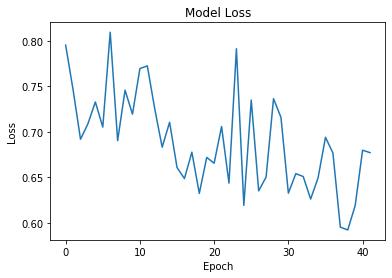

In [0]:
# remove outlier first epoch loss to prevent from squishing the graph down
del history.history['loss'][0]

viewModelLoss()